In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import cpi
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [38]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# Can close the connection since we're only doing one query
engine.dispose()

# Here I'm introducing an inflation adjusted sale price using the cpi module
house_prices_df['inf_adj_saleprice'] = house_prices_df.apply(lambda x: cpi.inflate(x.saleprice,x.yrsold), axis=1)

# Now I'm adding the CPI for both the years the house was built and sold
house_prices_df['cpi_yr_built'] = house_prices_df['yearbuilt'].apply(lambda x: cpi.get(x) if x > 1912 else 0)
house_prices_df['cpi_yr_sold'] = house_prices_df['yrsold'].apply(lambda x: cpi.get(x) if x > 1912 else 0)

# I'll combine the basement, first floor, and second floor square-footage features into one
# Then I'll multiply the total square-footage feathre by the overal qualitry rating to get a combined feature
house_prices_df['totalsf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']
house_prices_df['int_over_sf'] = house_prices_df['totalsf'] * house_prices_df['overallqual']

print(house_prices_df.head(10))

   id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   
5   6          50       RL         85.0    14115   Pave  None      IR1   
6   7          20       RL         75.0    10084   Pave  None      Reg   
7   8          60       RL          NaN    10382   Pave  None      IR1   
8   9          50       RM         51.0     6120   Pave  None      Reg   
9  10         190       RL         50.0     7420   Pave  None      Reg   

  landcontour utilities  ... mosold yrsold saletype salecondition saleprice  \
0         Lvl    AllPub  ...      2   2008       WD        Normal    208500   
1         Lvl    AllPub  ..

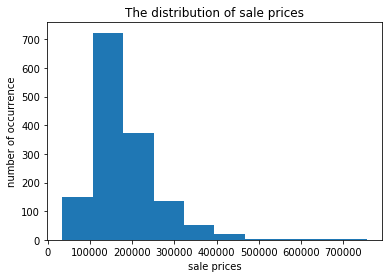

In [39]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

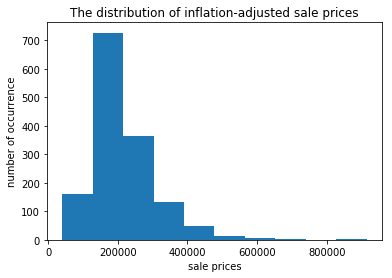

In [40]:
plt.hist(house_prices_df.inf_adj_saleprice)
plt.title("The distribution of inflation-adjusted sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

In [41]:
total_missing = house_prices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_prices_df.isnull().sum()/house_prices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagetype,81,0.055479
garagequal,81,0.055479
garagefinish,81,0.055479
garagecond,81,0.055479


In [42]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 86 columns):
id                   1460 non-null int64
mssubclass           1460 non-null int64
mszoning             1460 non-null object
lotfrontage          1201 non-null float64
lotarea              1460 non-null int64
street               1460 non-null object
alley                91 non-null object
lotshape             1460 non-null object
landcontour          1460 non-null object
utilities            1460 non-null object
lotconfig            1460 non-null object
landslope            1460 non-null object
neighborhood         1460 non-null object
condition1           1460 non-null object
condition2           1460 non-null object
bldgtype             1460 non-null object
housestyle           1460 non-null object
overallqual          1460 non-null int64
overallcond          1460 non-null int64
yearbuilt            1460 non-null int64
yearremodadd         1460 non-null int64
roofstyle          

In [43]:
# Here I'm splitting the db into numerical, numerical (that I consider categorical), and non-numerical categorical

df_num = house_prices_df.select_dtypes(include=['int64', 'float64'])
dropc = ['id', 'yrsold', 'overallqual', 'overallcond', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'mosold']
df3 = house_prices_df.loc[:, dropc]
df_obj = house_prices_df.select_dtypes(include=['object'])

# Here I'm dropping any int/float fields I consider to be categorical and not fit for a scatterplot. I'll us a bar plot for those
df2 = df_num.drop(dropc, axis = 1)
df3 = df3.drop('id', axis = 1)

df_num.info()
df3.info()
# print(df3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
id                   1460 non-null int64
mssubclass           1460 non-null int64
lotfrontage          1201 non-null float64
lotarea              1460 non-null int64
overallqual          1460 non-null int64
overallcond          1460 non-null int64
yearbuilt            1460 non-null int64
yearremodadd         1460 non-null int64
masvnrarea           1452 non-null float64
bsmtfinsf1           1460 non-null int64
bsmtfinsf2           1460 non-null int64
bsmtunfsf            1460 non-null int64
totalbsmtsf          1460 non-null int64
firstflrsf           1460 non-null int64
secondflrsf          1460 non-null int64
lowqualfinsf         1460 non-null int64
grlivarea            1460 non-null int64
bsmtfullbath         1460 non-null int64
bsmthalfbath         1460 non-null int64
fullbath             1460 non-null int64
halfbath             1460 non-null int64
bedroomabvgr         1460 no

In [44]:
np.abs(df_num.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice            1.000000
inf_adj_saleprice    0.997557
int_over_sf          0.856148
overallqual          0.790982
totalsf              0.782260
grlivarea            0.708624
garagecars           0.640409
garagearea           0.623431
totalbsmtsf          0.613581
firstflrsf           0.605852
cpi_yr_built         0.592246
fullbath             0.560664
totrmsabvgrd         0.533723
yearbuilt            0.522897
yearremodadd         0.507101
garageyrblt          0.486362
masvnrarea           0.477493
fireplaces           0.466929
bsmtfinsf1           0.386420
lotfrontage          0.351799
wooddecksf           0.324413
secondflrsf          0.319334
openporchsf          0.315856
halfbath             0.284108
lotarea              0.263843
bsmtfullbath         0.227122
bsmtunfsf            0.214479
bedroomabvgr         0.168213
kitchenabvgr         0.135907
enclosedporch        0.128578
screenporch          0.111447
poolarea             0.092404
mssubclass           0.084284
overallcon

Here we see the numeric features most correlated with the target variable. None of the top features seem to be missing many values, if at all (refer to the list of features with missing values above). Below we'll visualize these relationships.

In an effort to reduce collinearity I initially selected int_over_sf, grlivarea, garagearea for our model. I excluded the four components overallqual, totalsf, totalbsmtsf, firstflrsf and totalbsmtsf since they are all encompassed in the int_over_sf feature. I also excluded garagecars since that's very intuitively highly correlated with garagearea. 

However it seemed that excluding those 5 features resulted in a much weaker model resuts. There were larger generalization gaps and they were much more erroneous on average. I then cirlced back and included them back in (with the option to exclude them for reference).

I'll leave the cpi_yr_built out for now to show the split of how well the model works with and without the added feature.

In [97]:
col = ['int_over_sf', 'overallqual', 'totalsf', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'cpi_yr_built']

house_prices_df[col].corr()

,int_over_sf,overallqual,totalsf,grlivarea,garagecars,garagearea,totalbsmtsf,firstflrsf,cpi_yr_built
int_over_sf,1.000000,0.843040,0.938579,0.819653,0.587337,0.605201,0.775570,0.738604,0.547409
overallqual,0.843040,1.000000,0.668155,0.593007,0.600671,0.562022,0.537808,0.476224,0.682534
totalsf,0.938579,0.668155,1.000000,0.874373,0.536413,0.563747,0.826742,0.800350,0.411009
grlivarea,0.819653,0.593007,0.874373,1.000000,0.467247,0.468997,0.454868,0.566024,0.301162
garagecars,0.587337,0.600671,0.536413,0.467247,1.000000,0.882475,0.434585,0.439317,0.572924
garagearea,0.605201,0.562022,0.563747,0.468997,0.882475,1.000000,0.486665,0.489782,0.501879
totalbsmtsf,0.775570,0.537808,0.826742,0.454868,0.434585,0.486665,1.000000,0.819530,0.396371
firstflrsf,0.738604,0.476224,0.800350,0.566024,0.439317,0.489782,0.819530,1.000000,0.270833
cpi_yr_built,0.547409,0.682534,0.411009,0.301162,0.572924,0.501879,0.396371,0.270833,1.000000


In [85]:
# I left this here so I can go back and re-define the col list to see the difference in
# how well my model works with and without the 5 aforementioned variables
col = ['int_over_sf', 'grlivarea', 'garagearea']

house_prices_df[col].corr()

,int_over_sf,grlivarea,garagearea
int_over_sf,1.000000,0.819653,0.605201
grlivarea,0.819653,1.000000,0.468997
garagearea,0.605201,0.468997,1.000000


In [64]:
# Add in cpi_yr_built
col2 = col + ['cpi_yr_built']

house_prices_df[col2].corr()

,int_over_sf,grlivarea,garagearea,cpi_yr_built
int_over_sf,1.000000,0.819653,0.605201,0.547409
grlivarea,0.819653,1.000000,0.468997,0.301162
garagearea,0.605201,0.468997,1.000000,0.501879
cpi_yr_built,0.547409,0.301162,0.501879,1.000000


Numerical Features vs. Target Variable


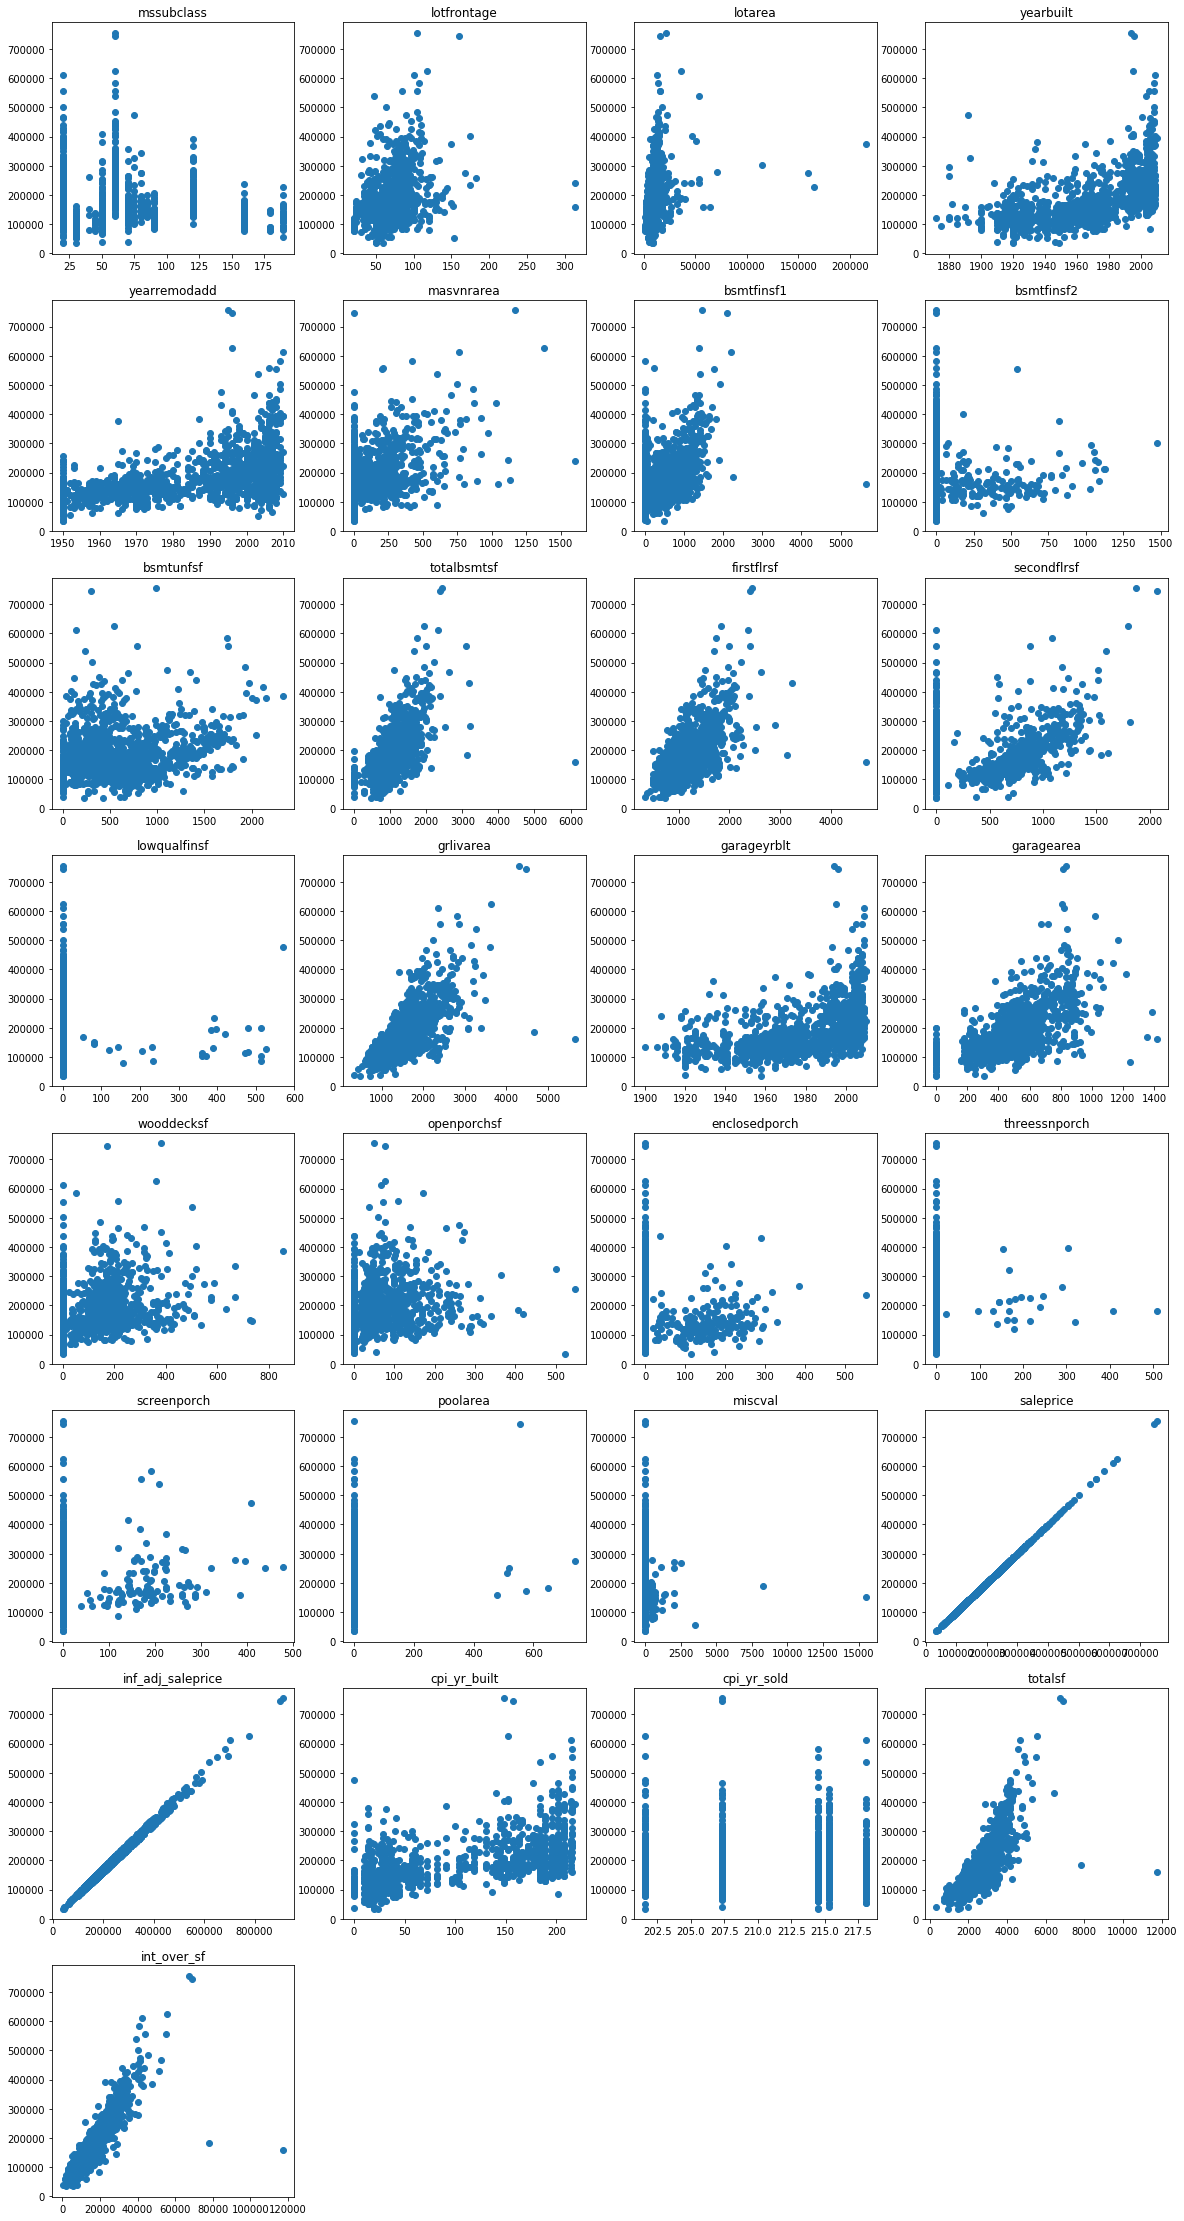

In [65]:
columns = df2.columns.unique()
plt.figure(figsize=(20, 40))

print('Numerical Features vs. Target Variable')
for i in range(1, len(columns) + 1):
    plt.subplot(8, 4, i)
    plt.scatter(x=house_prices_df[columns[i - 1]], y=house_prices_df['saleprice'])
    plt.title(columns[i - 1])

plt.show()

Categorical Features vs. Target Variable


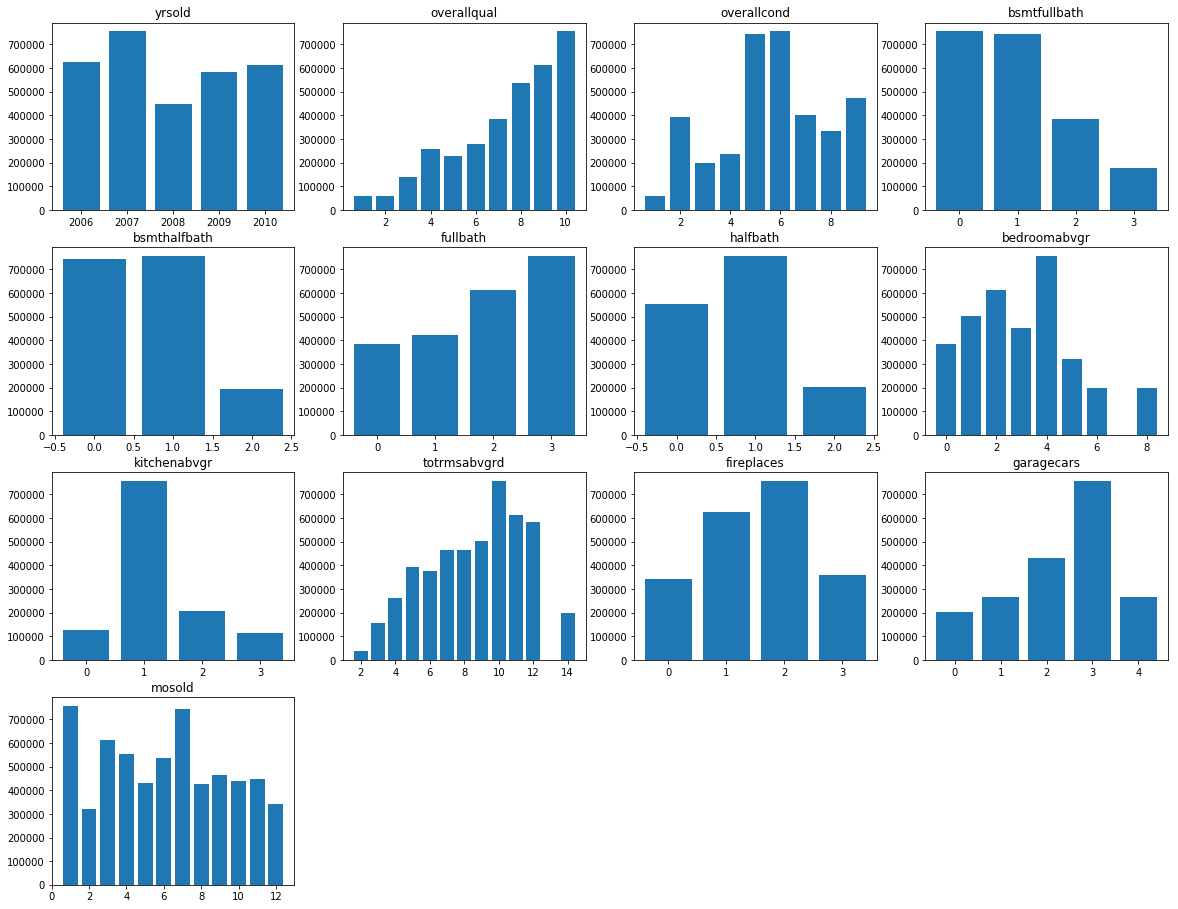

In [66]:
columns2 = df3.columns.unique()
plt.figure(figsize=(20, 20))

print('Categorical Features vs. Target Variable')
for i in range(1, len(columns2) + 1):
    plt.subplot(5, 4, i)
    plt.bar(house_prices_df[columns2[i - 1]], house_prices_df['saleprice'])
    plt.title(columns2[i - 1])

plt.show()

Below we take a look at the categorical variables and how they relate to sales price. Mszonging and street stick out as two that could be of use. 

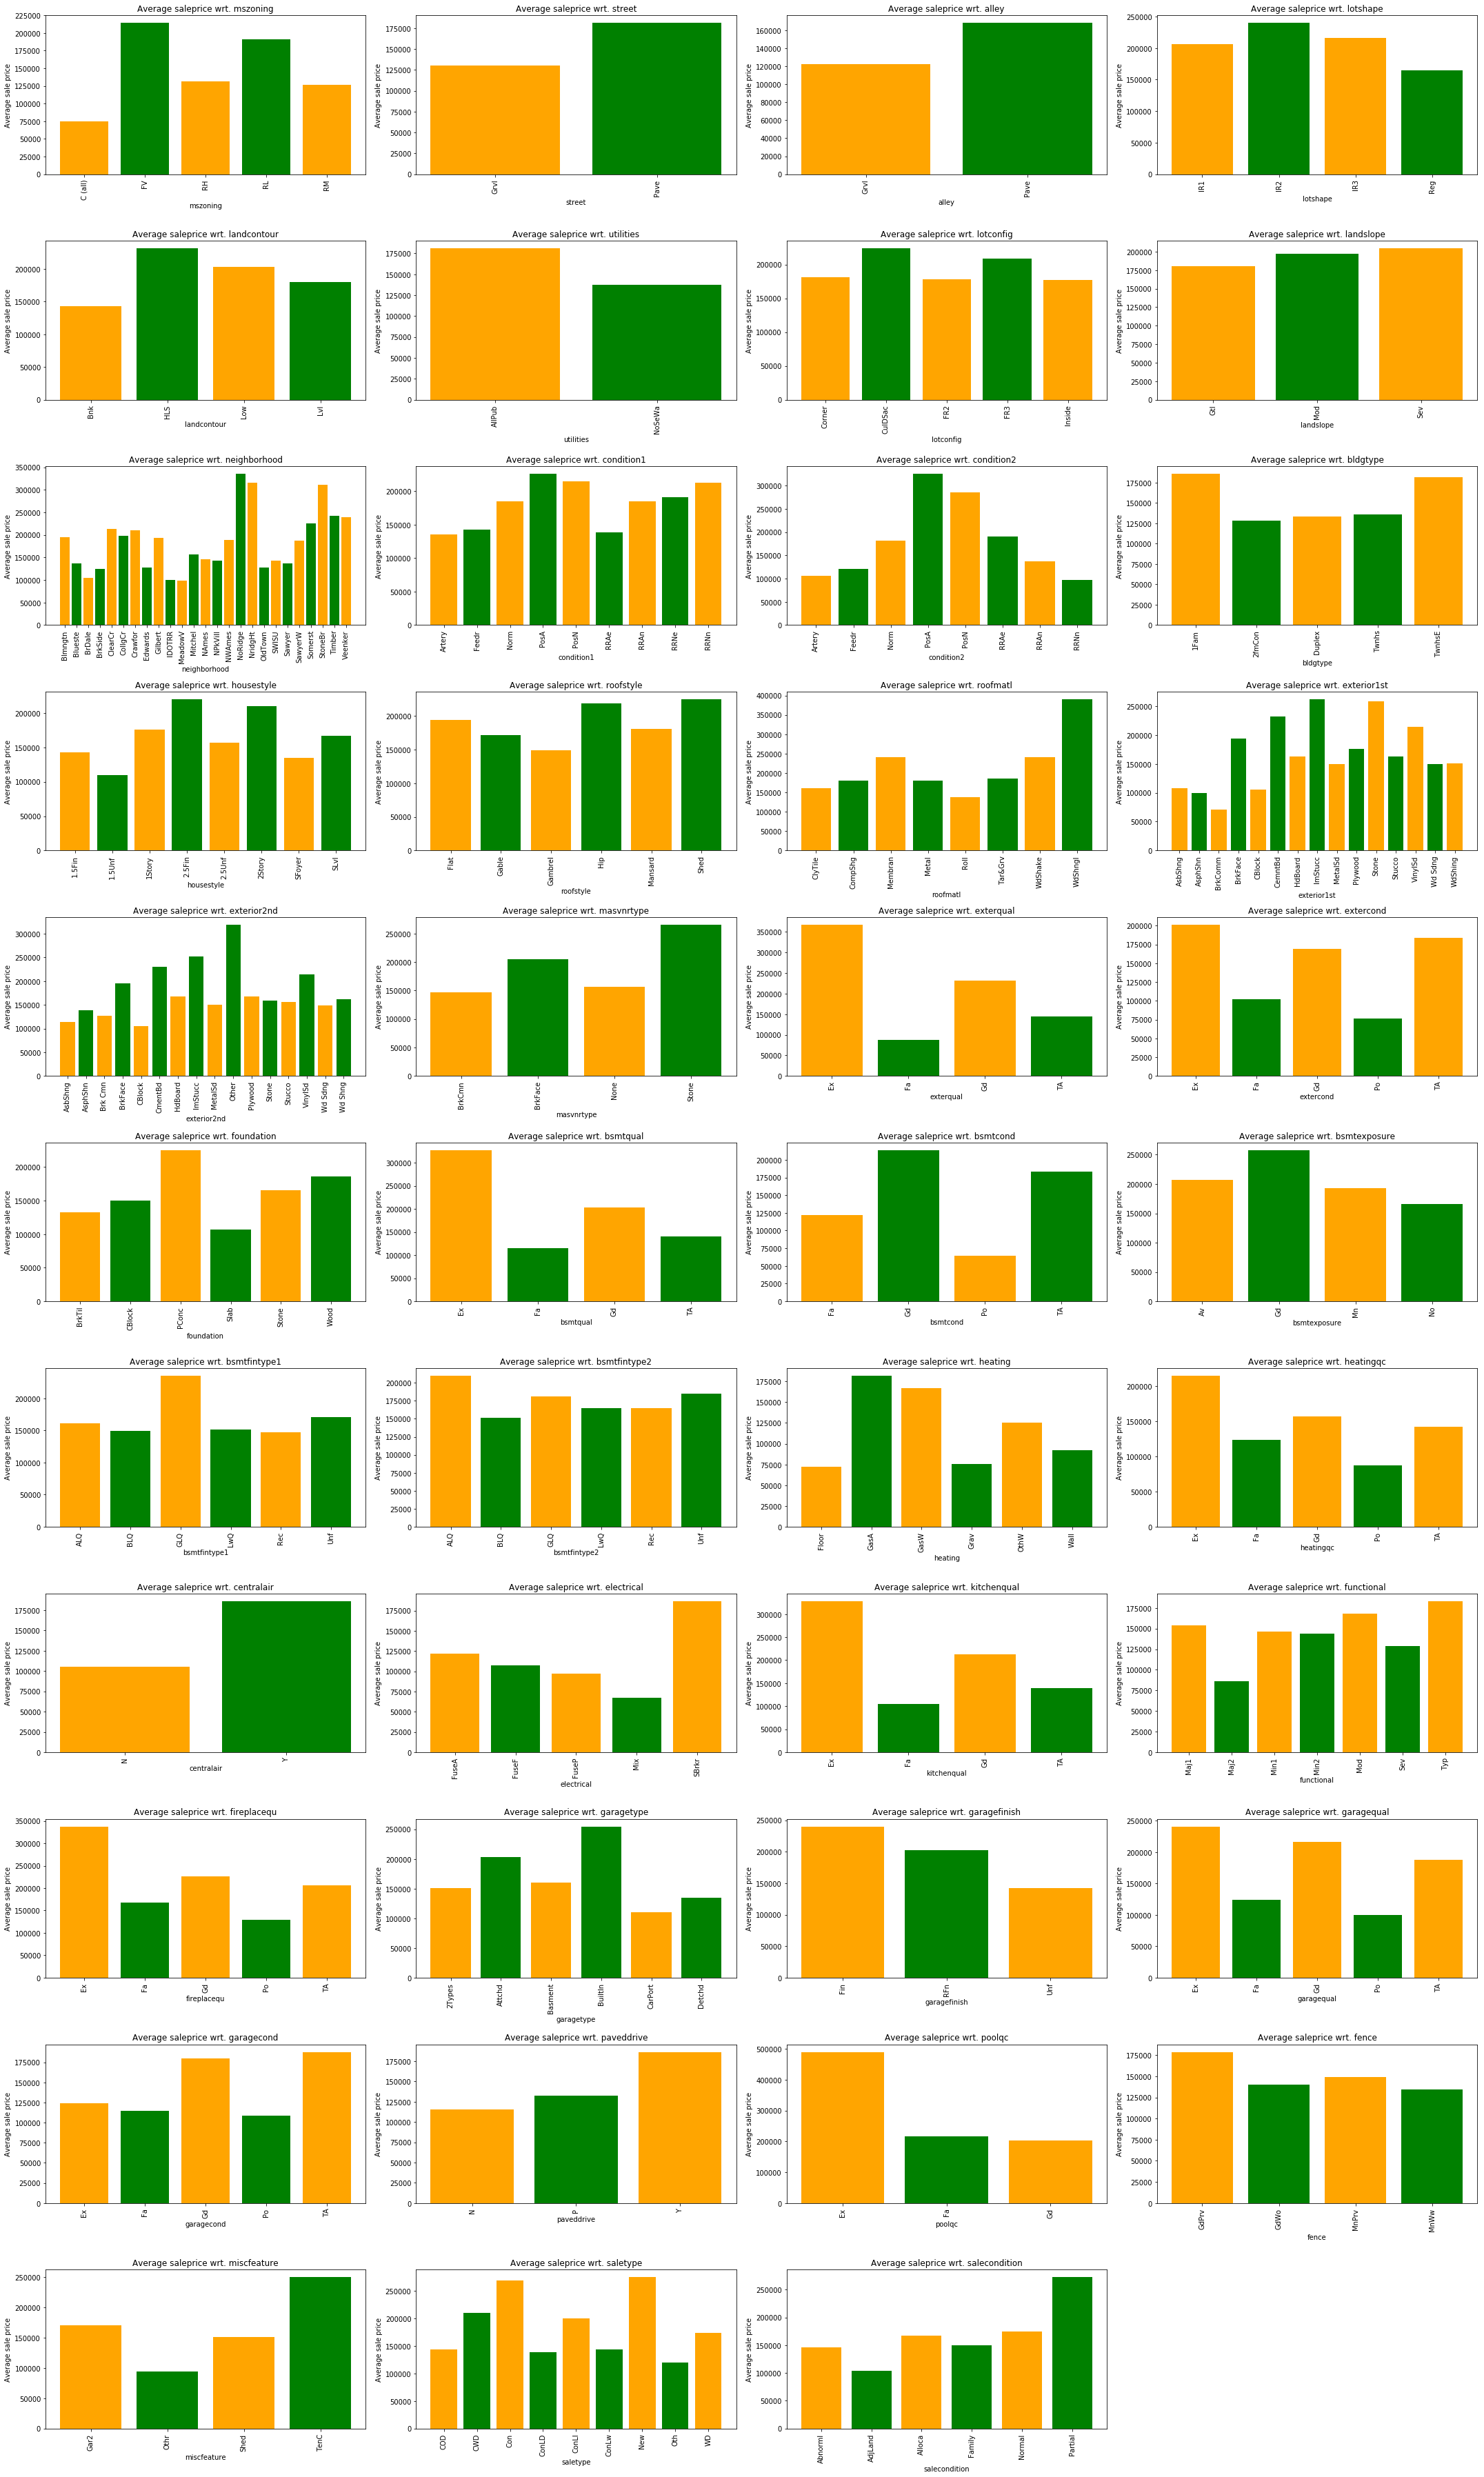

In [67]:
obj_col = df_obj.columns.unique()

plt.figure(figsize=(30,50))

for index, column in enumerate(obj_col):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(), color=('orange','green'))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [98]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [99]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df['mszoning'], prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

print(dummy_column_names)

['mszoning_FV', 'mszoning_RH', 'mszoning_RL', 'mszoning_RM', 'street_Pave']


In [101]:
# Y: Target Varialbe
Y = np.log1p(house_prices_df['saleprice'])
# X: features
X = house_prices_df[col + dummy_column_names]
# X: features extra two added
X2 = house_prices_df[col2 + dummy_column_names]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size = 0.2, random_state = 466)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

In [102]:
# ridge = Ridge()
# lrm = GridSearchCV(ridge, alphas, scoring = 'neg_mean_squared_error', cv = 5)

lrm = LinearRegression()
lrm.fit(X_train, y_train)

lrm2 = LinearRegression()
lrm2.fit(X_train2, y_train2)

# Predictions
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

y_preds_train2 = lrm2.predict(X_train2)
y_preds_test2 = lrm2.predict(X_test2)

print("Top 5 features")
print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("")
print("Next Two Features Added (including added cpi_yr_built)")
print("R-squared of the model in training set is: {}".format(lrm2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds_test2) / y_test2)) * 100))

Top 5 features
R-squared of the model in training set is: 0.8366728659697379
-----Test set statistics-----
R-squared of the model in test set is: 0.8359092326527219
Mean absolute error of the prediction is: 0.12219992442827216
Mean squared error of the prediction is: 0.02736142146618449
Root mean squared error of the prediction is: 0.16541288180242944
Mean absolute percentage error of the prediction is: 1.020057417888913

Next Two Features Added (including added cpi_yr_built)
R-squared of the model in training set is: 0.7841565867994944
-----Test set statistics-----
R-squared of the model in test set is: 0.8241755241195303
Mean absolute error of the prediction is: 0.11958174323356471
Mean squared error of the prediction is: 0.025808848782296598
Root mean squared error of the prediction is: 0.16065132673680788
Mean absolute percentage error of the prediction is: 0.9999848231492261


In [103]:
alphas = [np.power(10.0,p) for p in np.arange(-5,30,1)]

lasso = LassoCV(alphas=alphas)
lasso2 = LassoCV(alphas=alphas)
# print(lasso)

lasso.fit(X_train, y_train)
lasso2.fit(X_train2, y_train2)

y_preds_train = lasso.predict(X_train)
y_preds_test = lasso.predict(X_test)
y_preds_train2 = lasso2.predict(X_train2)
y_preds_test2 = lasso2.predict(X_test2)

print("Top 5 features")
print("Best alpha value is: {}".format(lasso.alpha_))
print("R-squared of the model in training set is: {}".format(lasso.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("")
print("Next Two Features Added (including added cpi_yr_built)")
print("Best alpha value is: {}".format(lasso2.alpha_))
print("R-squared of the model in training set is: {}".format(lasso2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds_test2) / y_test2)) * 100))

Top 5 features
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8341274867646996
-----Test set statistics-----
R-squared of the model in test set is: 0.8263953800796564
Mean absolute error of the prediction is: 0.12394034440476803
Mean squared error of the prediction is: 0.028947814986228594
Root mean squared error of the prediction is: 0.1701405741915449
Mean absolute percentage error of the prediction is: 1.0360178911812048

Next Two Features Added (including added cpi_yr_built)
Best alpha value is: 0.0001
R-squared of the model in training set is: 0.7840221051989354
-----Test set statistics-----
R-squared of the model in test set is: 0.8242973136415261
Mean absolute error of the prediction is: 0.11953120213036338
Mean squared error of the prediction is: 0.025790971593465415
Root mean squared error of the prediction is: 0.1605956773810099
Mean absolute percentage error of the prediction is: 0.9994873989371883


In [106]:
ridge = RidgeCV(alphas=alphas)
ridge2 = RidgeCV(alphas=alphas)
# print(ridge)

ridge.fit(X_train, y_train)
ridge2.fit(X_train2, y_train2)

y_preds_train = ridge.predict(X_train)
y_preds_test = ridge.predict(X_test)
y_preds_train2 = ridge2.predict(X_train2)
y_preds_test2 = ridge2.predict(X_test2)

print("Top 5 features")
print("Best alpha value is: {}".format(ridge.alpha_))
print("R-squared of the model in training set is: {}".format(ridge.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("")
print("Next Two Features Added (including added cpi_yr_built)")
print("Best alpha value is: {}".format(ridge2.alpha_))
print("R-squared of the model in training set is: {}".format(ridge2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds_test2) / y_test2)) * 100))

Top 5 features
Best alpha value is: 1.0
R-squared of the model in training set is: 0.8366627438790104
-----Test set statistics-----
R-squared of the model in test set is: 0.8354352995423174
Mean absolute error of the prediction is: 0.12228425730742942
Mean squared error of the prediction is: 0.02744044775017469
Root mean squared error of the prediction is: 0.1656515854140089
Mean absolute percentage error of the prediction is: 1.0208552795429382

Next Two Features Added (including added cpi_yr_built)
Best alpha value is: 1.0
R-squared of the model in training set is: 0.7841281853890124
-----Test set statistics-----
R-squared of the model in test set is: 0.8242409384188607
Mean absolute error of the prediction is: 0.11955998141699081
Mean squared error of the prediction is: 0.02579924677580027
Root mean squared error of the prediction is: 0.1606214393404575
Mean absolute percentage error of the prediction is: 0.9997685445370281


In [105]:
elasticnet = ElasticNetCV(alphas=alphas, cv=5)
elasticnet2 = ElasticNetCV(alphas=alphas, cv=5)

elasticnet.fit(X_train, y_train)
elasticnet2.fit(X_train2, y_train2)

# We are making predictions here
y_preds_train = elasticnet.predict(X_train)
y_preds_test = elasticnet.predict(X_test)
y_preds_train2 = elasticnet2.predict(X_train2)
y_preds_test2 = elasticnet2.predict(X_test2)

print("Top 5 features")
print("Best alpha value is: {}".format(elasticnet.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print("")
print("Next Two Features Added (including added cpi_yr_built)")
print("Best alpha value is: {}".format(elasticnet2.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet2.score(X_train2, y_train2)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet2.score(X_test2, y_test2)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test2, y_preds_test2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test2, y_preds_test2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test2, y_preds_test2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test2 - y_preds_test2) / y_test2)) * 100))

Top 5 features
Best alpha value is: 0.001
R-squared of the model in training set is: 0.8344534933415623
-----Test set statistics-----
R-squared of the model in test set is: 0.8257253434133925
Mean absolute error of the prediction is: 0.12436140161014106
Mean squared error of the prediction is: 0.029059540684875866
Root mean squared error of the prediction is: 0.1704685914908546
Mean absolute percentage error of the prediction is: 1.039551537731993

Next Two Features Added (including added cpi_yr_built)
Best alpha value is: 0.0001
R-squared of the model in training set is: 0.7841162745867014
-----Test set statistics-----
R-squared of the model in test set is: 0.8242442274099233
Mean absolute error of the prediction is: 0.11955126350398945
Mean squared error of the prediction is: 0.02579876399277159
Root mean squared error of the prediction is: 0.16061993647356354
Mean absolute percentage error of the prediction is: 0.999693528170475


Accorindg to these results, the OLS and the Ridge regression models worked the best. They're very close, but the OLS is slightly less erroneous so I'll go with that one. Adding in the CPI feature reduced model error, but it increased the generalization gap in all of the models so I decided to not include it.